# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [217]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [218]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: здесь мы считаем не определяем класс каждого объекта, а считаем *вероятность* его принадлежности к классу 0 или 1, поэтому числа будут лежать в интервале $[0, 1]$.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [219]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


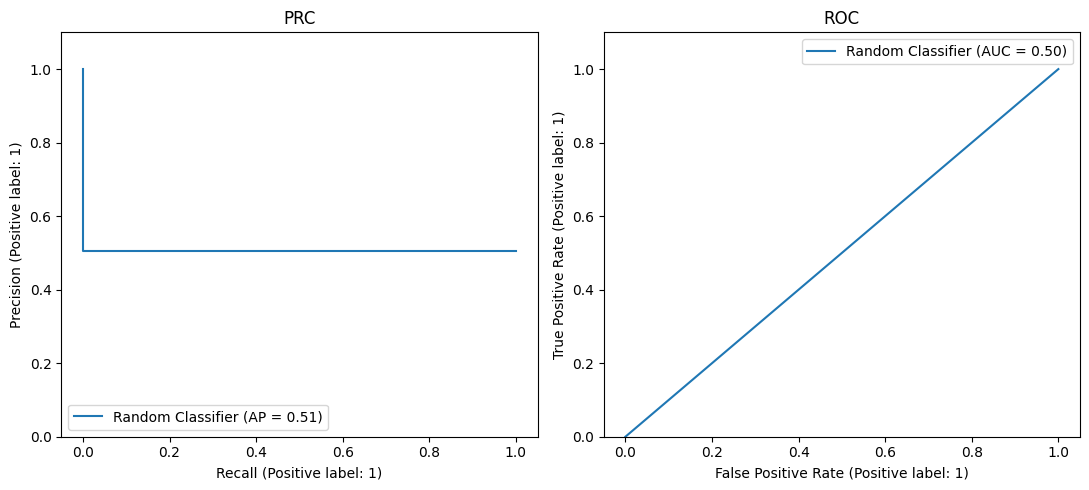

In [220]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [221]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [229]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

linear_svm_preprocessor = ColumnTransformer([
    ('scaling', StandardScaler(), [i for i in range(10)]),
])


linear_svm_pipeline = Pipeline(steps=[
    ('preprocessing', linear_svm_preprocessor),
    ('training', LinearSVC())
])

#Перед этим я попробовала до 100, 10, 1. В итоге, так как лучшее значение получилось порядка
#3*10^-4, логично поделать около него побольше итераций
linear_svm_param_grid = {'training__C': np.logspace(np.log10(10**-4), np.log10(10**-3), num=100)}
linear_svm_grid_search = GridSearchCV(linear_svm_pipeline, linear_svm_param_grid, cv=5, scoring='average_precision')
linear_svm_grid_search.fit(X_train, y_train)

linear_svm_model = linear_svm_grid_search.best_estimator_
print("Best C:", linear_svm_model.named_steps['training'].C)

Best C: 0.0003053855508833416


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM Classifier metrics
AUC-PR: 0.83115
AUC-ROC: 0.84603


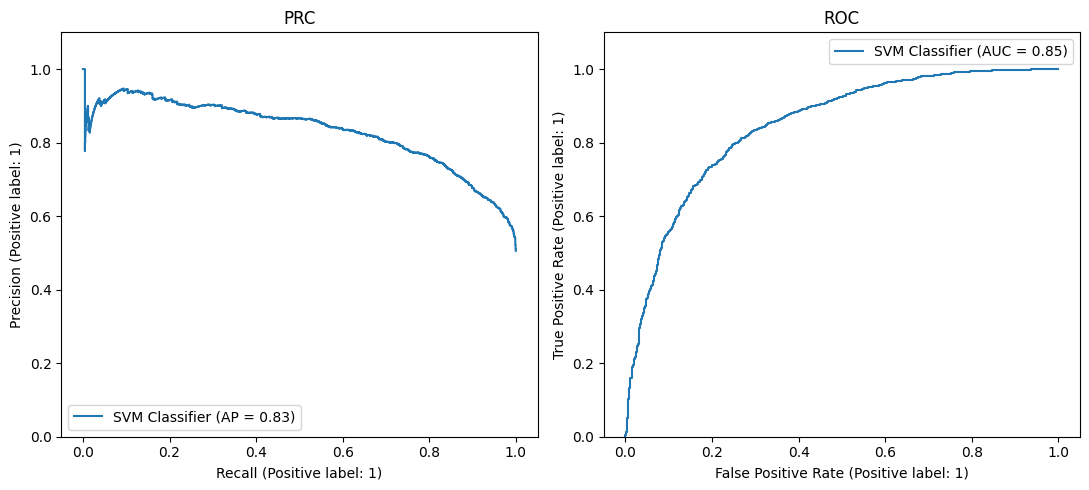

In [230]:
linear_svm_decision_values = linear_svm_model.decision_function(X_test)
linear_svm_y_proba = 1 / (1 + np.exp(-linear_svm_decision_values))

depict_pr_roc(y_test, linear_svm_y_proba, 'SVM Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [231]:
precision, recall, _ = precision_recall_curve(y_test, linear_svm_y_proba)
df_metrics.loc['SVM Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, linear_svm_y_proba),
      linear_svm_model.named_steps['training'].C
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.831149,0.846026,0.000305
Logistic Regression Classifier,0.830843,0.845706,0.002477


Видим, что площадь AUC_ROC и AUC_PR значительно выросли, а значит, качество модели улучшилось (ну ещё бы, по сравнению с рандомом-то...)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [232]:
from sklearn.linear_model import LogisticRegression

logistic_regression_preprocessor = ColumnTransformer([
    ('scaling', StandardScaler(), [i for i in range(10)]),
])


logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessing', logistic_regression_preprocessor),
    ('training', LogisticRegression(penalty='l2'))
])

#Аналогично, только лучшее значение было порядка 3*10^-3
logistic_regression_param_grid = {'training__C': np.logspace(np.log10(10**-3), np.log10(10**-2), num=100)}
logistic_regression_grid_search = GridSearchCV(logistic_regression_pipeline, logistic_regression_param_grid, cv=5, scoring='average_precision')
logistic_regression_grid_search.fit(X_train, y_train)

logistic_regression_model = logistic_regression_grid_search.best_estimator_
print("Best C:", logistic_regression_model.named_steps['training'].C)

Best C: 0.0024770763559917113


SVM Classifier metrics
AUC-PR: 0.83084
AUC-ROC: 0.84571


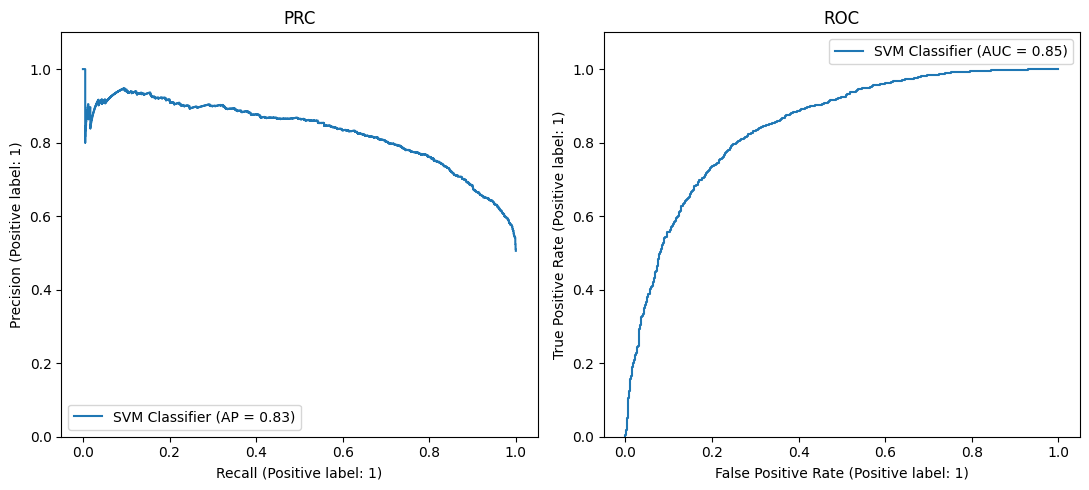

In [233]:
logistic_regression_y_proba = logistic_regression_model.predict_proba(X_test)[:,1]

depict_pr_roc(y_test, logistic_regression_y_proba, 'SVM Classifier')

In [234]:
precision, recall, _ = precision_recall_curve(y_test, logistic_regression_y_proba)
df_metrics.loc['Logistic Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, logistic_regression_y_proba),
      logistic_regression_model.named_steps['training'].C
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.831149,0.846026,0.000305
Logistic Regression Classifier,0.830843,0.845706,0.002477


По сравнению со случайным классификатором снова видим заметный прирост качества.

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
Linear SVM Classifier metrics
AUC-PR: 0.83115
AUC-ROC: 0.84603
Logistic Regression Classifier metrics
AUC-PR: 0.83084
AUC-ROC: 0.84571


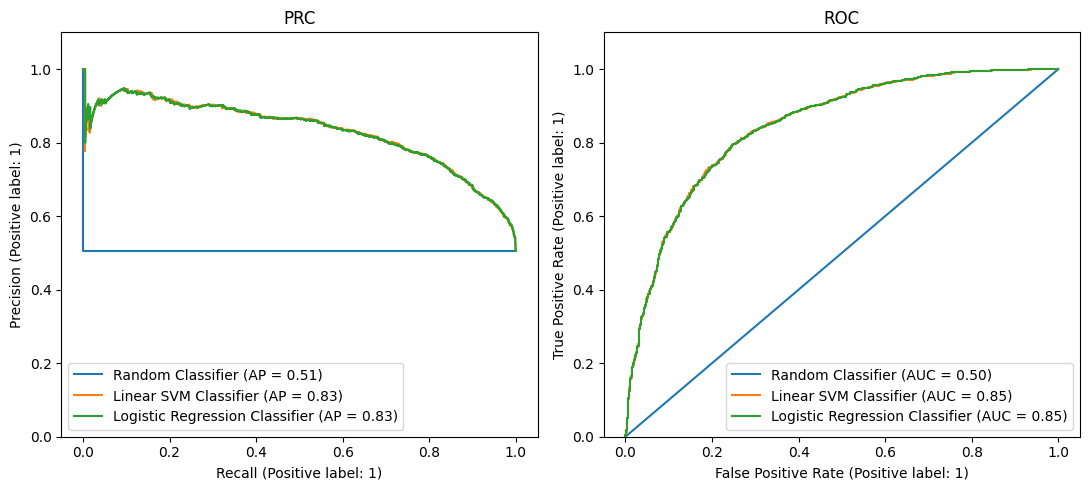

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, linear_svm_y_proba, 'Linear SVM Classifier', ax)
depict_pr_roc(y_test, logistic_regression_y_proba, 'Logistic Regression Classifier', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** PRC и ROC для методов LR и SVM получились почти неотличимыми, при этом по сравнению со случайным классификатором качество сильно выросло.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [236]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

In [237]:
from sklearn.svm import SVC

linear_svm_model = SVC(kernel='linear')
linear_svm_model.fit(X, y)

SVC(kernel='linear')

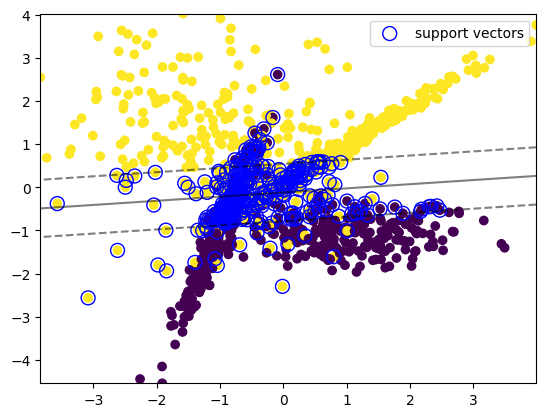

In [238]:
np.random.seed(42)

def plot_svm_2D(X, y, model, plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], 
                X[:, 1], 
                c=y, 
                linewidth=1)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, linear_svm_model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** как опорные выделяются объекты, которые либо находятся внутри разделяющей полосы, либо не соответствуют своему классу.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [239]:
logistic_regression_model = LogisticRegression(penalty='l2')
logistic_regression_model.fit(X, y)

LogisticRegression()

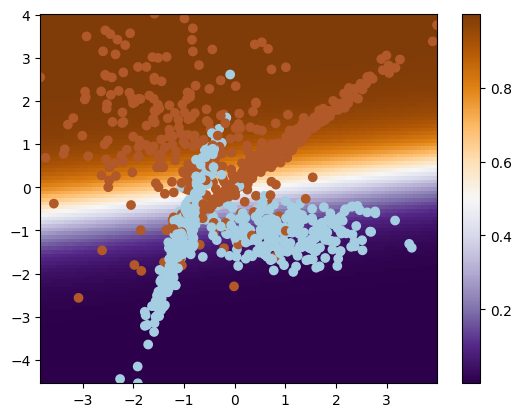

In [240]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], 
                X[:, 1], 
                c=y, 
                linewidth=1,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, logistic_regression_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** чем меньше модель уверена в своём ответе, тем светлее область. По белой линии проходит разделяющая плоскость (прямая), светлые полосы вокруг неё соответствуют разделяющей полосе. Действительно, если объект находится близко к разделяющей плоскости, то малейшее колебание изменение весов в модели может изменить его класс. Поэтому чем ближе объект к разделяющей плоскости, тем меньше модель уверена в своём ответе.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [241]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        #bin_middle_points.append((l - r) / 2)
        bin_middle_points.append((l + r) / 2) 
        #bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)]))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [258]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [260]:
#берём оптимальные С из предпредыдущего задания
linear_svm_model = SVC(kernel = 'linear', C=0.0003053855508833416, probability=True)
linear_svm_model.fit(X_train, y_train)

linear_svm_dec_vals = linear_svm_model.predict_proba(X_test)[:,1]
linear_svm_y_pred = (linear_svm_dec_vals - linear_svm_dec_vals.min()) / \
    (linear_svm_dec_vals.max() - linear_svm_dec_vals.min())

logistic_regression_model = LogisticRegression(C=0.0024770763559917113)
logistic_regression_model.fit(X_train, y_train)

logistic_regression_y_pred = logistic_regression_model.predict_proba(X_test)[:, 1]

<Figure size 1000x1000 with 0 Axes>

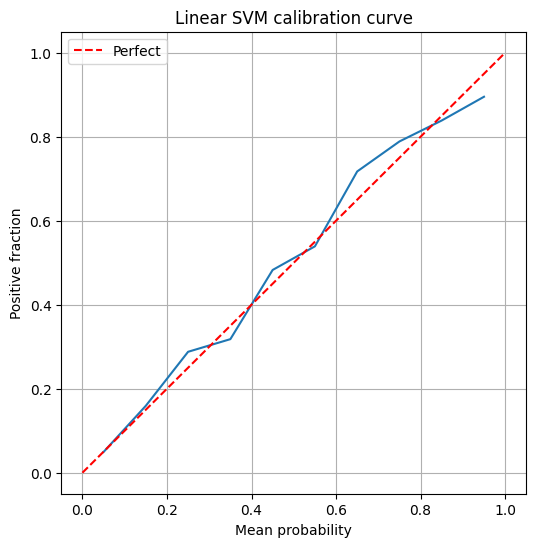

In [261]:
plt.figure(figsize=(10, 10))

plot_calibration_curve(y_test, linear_svm_y_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='red')

plt.title('Linear SVM calibration curve')
plt.xlabel('Mean probability')
plt.ylabel('Positive fraction')
plt.legend()
plt.show()

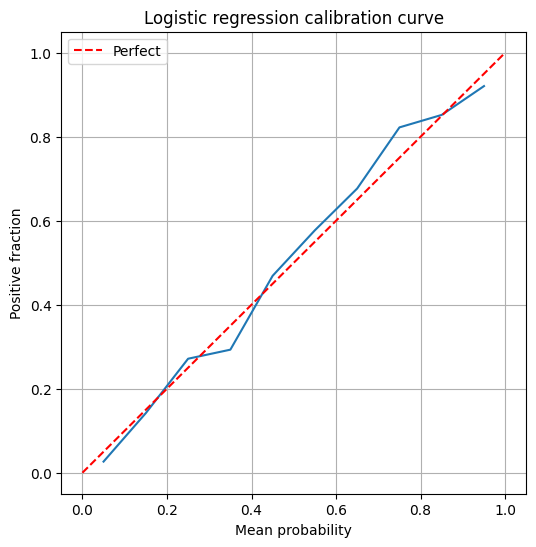

In [262]:
# plt.figure(figsize=(10, 10))

plot_calibration_curve(y_test, logistic_regression_y_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='red')

plt.title('Logistic regression calibration curve')
plt.xlabel('Mean probability')
plt.ylabel('Positive fraction')
plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** обе достаточно хорошо откалиброваны.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

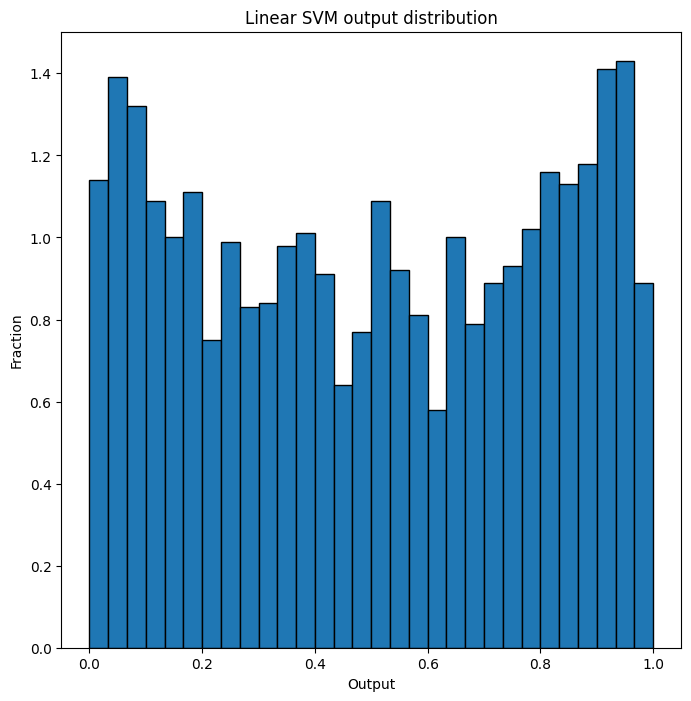

In [263]:
plt.figure(figsize=(8, 8))
plt.hist(linear_svm_y_pred, bins=30, edgecolor='black', density='True')
plt.title('Linear SVM output distribution')
plt.xlabel('Output')
plt.ylabel('Fraction')
plt.show()

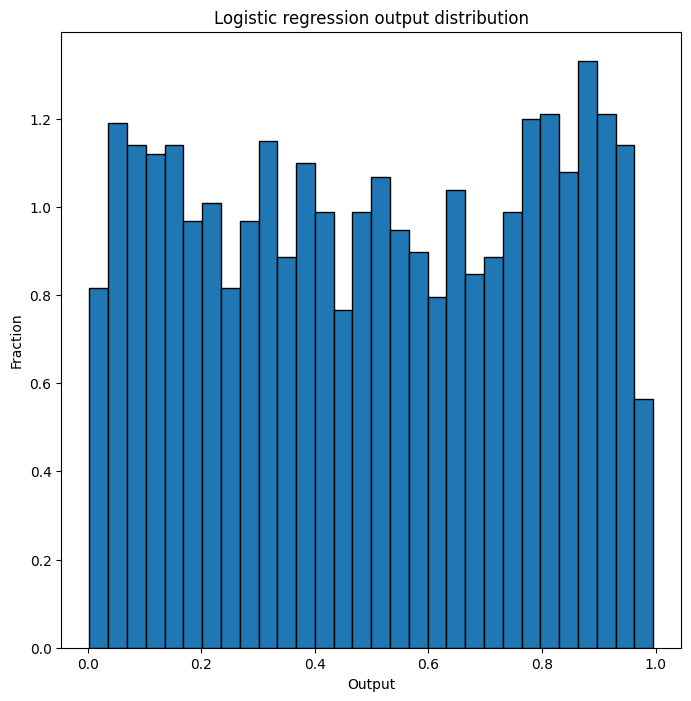

In [264]:
plt.figure(figsize=(8, 8))
plt.hist(logistic_regression_y_pred, bins=30, edgecolor='black', density='True')
plt.title('Logistic regression output distribution')
plt.xlabel('Output')
plt.ylabel('Fraction')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** у логистической регрессии распределение больше приближено к равномерному. Различия в кривых и распределении ответов можно объяснить тем, что логистическая регрессия изначально, теоретически выведена, как метод, который приближает реальные вероятности, в то время как SVM действует из других соображений — он пытается максимизировать ширину разделяющей полосы, поэтому даёт более уверенные предсказания.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

<Figure size 700x700 with 0 Axes>

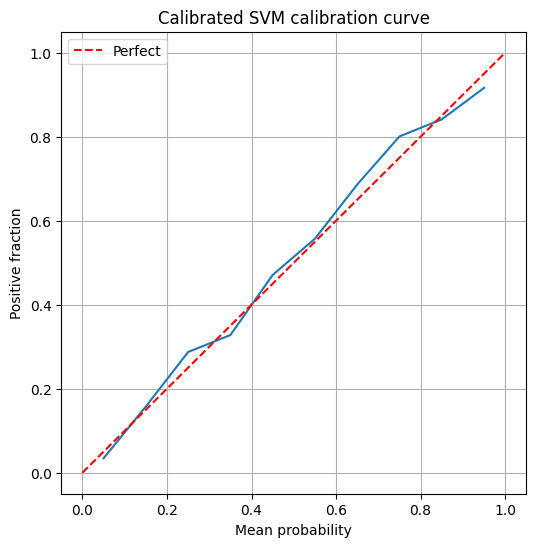

In [269]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm_model = CalibratedClassifierCV(linear_svm_model)
calibrated_svm_model.fit(X_train, y_train)

plt.figure(figsize=(7, 7))
plot_calibration_curve(y_test, calibrated_svm_model.predict_proba(X_test)[:, 1])
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='red')
plt.title('Calibrated SVM calibration curve')
plt.xlabel('Mean probability')
plt.ylabel('Positive fraction')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да, калибровочная кривая немного улучшилась (но не сильно).

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [271]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [652]:
df = pd.read_csv('bike_buyers.csv')
df.head(5)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [653]:
#Заменим пропуски категориальных переменных
string_columns = df.select_dtypes(include='object').columns
df[string_columns] = df[string_columns].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[X.select_dtypes(exclude='object').columns]
X_categorical = X[X.select_dtypes(include='object').columns]

В начале поработаем только с категориальными признаками

In [654]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [655]:
import time

def train_and_measure_quality(encoder):
    pipeline = Pipeline(steps=[
        ('encoding', encoder),
        ('regression', LogisticRegression())
    ])

    start = time.time()
    model = pipeline.fit(X_train, y_train)
    end = time.time()

    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    print('PR-AUC: %.5f' %(auc(recall, precision)))
    print('Training time:', end - start)

In [656]:
from sklearn.preprocessing import OrdinalEncoder

train_and_measure_quality(OrdinalEncoder())

PR-AUC: 0.57894
Training time: 0.018665552139282227


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [657]:
from sklearn.preprocessing import OneHotEncoder

train_and_measure_quality(OneHotEncoder())

PR-AUC: 0.66186
Training time: 0.04728436470031738


Качество модели довольно заметно улучшилось при One-Hot кодировании.

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [658]:
from sklearn.preprocessing import FunctionTransformer

train_combined = pd.concat([X_train, y_train], axis=1)

def mean_target_encoder(data, columns):
    for column in columns:
        mean = train_combined.groupby(column)['Purchased Bike'].mean()
        data[column] = data[column].map(mean)
    return data

mte = FunctionTransformer(mean_target_encoder, kw_args={'columns': X_categorical.columns})

train_and_measure_quality(mte)

PR-AUC: 0.65269
Training time: 0.031018972396850586


Время как будто везде при обучении получилось сопоставимое. Возможно, различия сильнее заметны на бОльшем размере выборки или количестве признаков.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [659]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [660]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None):
        self.cols = cols
        
    def fit(self, X, y):
        if self.cols == None:
            self.cols = X.select_dtypes(include='object').columns
        
        self.maps = {col: y.groupby(X[col]).mean().to_dict() for col in self.cols}
        return self

        
    def transform(self, X, y=None):
        X_copy = X.copy()

        for col, tmap in self.maps.items():
            X_copy[col] = X[col].map(tmap)

        return X_copy
            
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [661]:
train_and_measure_quality(TargetEncoder())

PR-AUC: 0.65269
Training time: 0.04197263717651367


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [662]:
class TargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None, noise_level=0.01):
        self.cols = cols
        self.noise_level = noise_level
        
    def fit(self, X, y):
        if self.cols == None:
            self.cols = X.select_dtypes(include='object').columns
            
        self.maps = {col: y.groupby(X[col]).mean().to_dict() for col in self.cols}
        return self

        
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        for col, tmap in self.maps.items():
            X_copy[col] = X[col].map(tmap)
            X_copy[col] += np.random.normal(0, self.noise_level, X_copy.shape[0])

        return X_copy
            
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    

In [502]:
train_and_measure_quality(TargetEncoderWithNoise())

PR-AUC: 0.66363
Training time: 0.04058980941772461


Ну так, не то чтобы особо лучше стало даже при нормально подобранном значении шума.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [585]:
from sklearn.model_selection import KFold

class TargetEncoderWithNoiseAndFolding(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None, noise_level=0.02, cv=5):
        self.cols = cols
        self.noise_level = noise_level
        self.cv = cv
        self.kfold = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        
    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.select_dtypes(include=['object', 'number']).columns
            
        self.maps = {}
        for col in self.cols:
            map_fold = {}

            for train_idx, test_idx in self.kfold.split(X, y):
                X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
                
                mean = y_train_fold.groupby(X_train_fold[col]).mean().to_dict()
                map_fold.update(mean)

                X_test_fold, y_test_fold = X.iloc[test_idx], y.iloc[test_idx]
                X_test_fold.loc[:, col] = X_test_fold[col].map(mean)
                X_test_fold.loc[:, col] += np.random.normal(0, self.noise_level, X_test_fold.shape[0])

                self.maps[col] = map_fold
        
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        
        for col, tmap in self.maps.items():
            X_copy[col] = X[col].map(tmap)
            X_copy[col] += np.random.normal(0, self.noise_level, X_copy.shape[0])

        return X_copy
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [572]:
train_and_measure_quality(TargetEncoderWithNoiseAndFolding())

PR-AUC: 0.67172
Training time: 0.17090320587158203


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [663]:
class TargetEncoderWithSmoothing(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None):
        self.cols = cols
        self.C = 6.0
        
    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.select_dtypes(include='object').columns
            
        self.global_mean = y.mean()
        self.maps = {col: self.C_mean(X[col], y) for col in self.cols}
        
        return self

    def C_mean(self, X_col, y):
        count = y.groupby(X_col).count()
        mean = y.groupby(X_col).mean()
        C_mean = (count * mean + self.C * self.global_mean) / (count + self.C)
        return C_mean.to_dict()

    def transform(self, X, y=None):
        X_copy = X.copy()

        for col, tmap in self.maps.items():
            X_copy[col] = X_copy[col].map(lambda x: tmap.get(x, self.global_mean))

        return X_copy
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [664]:
train_and_measure_quality(TargetEncoderWithSmoothing())

PR-AUC: 0.67082
Training time: 0.031667470932006836


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [665]:
X[X_numerical.columns] = X[X_numerical.columns].apply(lambda col: col.fillna(col.mean()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [683]:
def train_and_measure_quality_with_scaling(encoder, categorical, numerical):
    preprocessor = ColumnTransformer([
        ('encoding', encoder, categorical),
        ('scaling', StandardScaler(), numerical)
    ], remainder='drop')
    
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('regression', LogisticRegression())
    ])

    model = pipeline.fit(X_train, y_train)

    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    print('PR-AUC: %.5f' %(auc(recall, precision)))

In [667]:
for column in X_numerical.columns:
    print(f'{column}: {X[column].nunique()}')

ID: 1000
Income: 17
Children: 7
Cars: 6
Age: 54


In [668]:
X_numerical = ['Income', 'Children', 'Cars', 'Age']

for column in X_numerical:
    categorical = list(X_categorical.columns) + [column]
    numerical = list(set(X_numerical).difference([column]))
    print(f'{column} ', end='')
    train_and_measure_quality_with_scaling(TargetEncoderWithSmoothing(), categorical, numerical)
    
print('All ', end='')
train_and_measure_quality_with_scaling(TargetEncoderWithSmoothing(), list(X_categorical.columns) + X_numerical, [])

Income PR-AUC: 0.44578
Children PR-AUC: 0.68471
Cars PR-AUC: 0.68428
Age PR-AUC: 0.68570
All PR-AUC: 0.57494


/home/cutehater/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Как видим, кодировка всех признаков, кроме `Income` улучшила качество, а вот кодировка `Income` ощутимо ухудшила. Да и в целом, довольно логично, что зависимость купит/не купит человек товар весьма похожа на линейную по признаку дохода. Ради интереса давайте ещё попробуем посчитать качество, закодировав все три признака, кроме `Income`.

In [670]:
train_and_measure_quality_with_scaling(TargetEncoderWithSmoothing(), list(X_categorical.columns) + ['Children', 'Cars', 'Age'], ['Income'])

PR-AUC: 0.68327


/home/cutehater/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ ясно, что mean target encoding не увеличивает число признаков, в то время как при one-hot их количество может расти в разы. У нас, видимо, было суммарно немного различных значений категориальных признаков, поэтому это было не очень ощутимо, но на бОльшем их числе mean target будет выигрывать по времени и памяти. Качество и там, и там получилось довольно хорошим, после определённых махинаций с mean target методом получилось сделать его немного лучше по сравнению с One-hot. В то же время mean target больше склонен к переобучению и утечке целевой переменной, и за этим необходимо дополнительно следить.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [718]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-23 17:06:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.3’

adult.data.3            [                <=> ]   3,79M   999KB/s    in 3,9s    

2023-11-23 17:07:01 (999 KB/s) - ‘adult.data.3’ saved [3974305]



In [837]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16511,22,Self-emp-not-inc,357612,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [838]:
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [839]:
categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(exclude='object').columns

encoder = OneHotEncoder().fit(X_train[categorical])

categories_num = sum(len(encoder.categories_[i]) - 1 for i in range(len(categorical)))
print("Number of new features:", categories_num)

Number of new features: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [858]:
def get_preprocessor(ptype):
    if ptype == 'default':
        return ColumnTransformer([
            ('encoding', OneHotEncoder(), categorical),
            ('scaling', StandardScaler(), numerical)
        ], remainder='drop')
    elif ptype == 'unscaled':
        return ColumnTransformer([
            ('encoding', OneHotEncoder(), categorical)
        ], remainder='passthrough')
    elif ptype == 'unsparse':
        return ColumnTransformer([
            ('encoding', OneHotEncoder(sparse_output=False), categorical),
            ('scaling', StandardScaler(), numerical)
        ])
    
def measure_time_and_quality(pipeline, X_train_=X_train, y_train_=y_train, X_test_=X_test):
    start = time.time()
    model = pipeline.fit(X_train_, y_train_)
    end = time.time()

    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_)[:,1])
    print('PR-AUC: %.5f' %(auc(recall, precision)))
    print('Training time:', end - start)
    
    return model

In [843]:
pipeline = Pipeline(steps=[
        ('preprocessing', get_preprocessor('default')),
        ('regression', LogisticRegression(max_iter=5000))
])

default_model = measure_time_and_quality(pipeline)

PR-AUC: 0.76713
Training time: 0.9551632404327393


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [844]:
class BestWeightsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, weights):
        self.weights = weights.argsort()[-40:]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.copy()[:, self.weights]

In [845]:
pipeline = Pipeline(steps=[
    ('preprocessing', get_preprocessor('default')),
    ('features_selection', BestWeightsTransformer(default_model['regression'].coef_[0])),
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline)

PR-AUC: 0.76402
Training time: 0.47432398796081543


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoding', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('scaling', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('features_selection',
                 BestWeightsTransformer(weights=array([ 57,  98,  33,  19,   4,  23,  35, 106,  48, 101,   5,  54,  74,
       102, 107,  96,  99,  59,  44,  69,  65,  84,  90,  42,  12,  13,
         1,  45, 104,  43,  82,  70,  71,  61,  62,  36,  52,  27,  26,
       105]))),
                ('regression', LogisticRegression(max_iter=5000))])

Изменилось ли качество? Как?

Качество практически не изменилось (ухудшилось на 0.003), зато уменьшилось время на обучение модели (почти в 2 раза).

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [846]:
pipeline = Pipeline(steps=[
    ('preprocessing', get_preprocessor('unscaled')),
    ('regression', LogisticRegression(max_iter=5000))
])
unscaled_model = measure_time_and_quality(pipeline)

PR-AUC: 0.45033
Training time: 0.316800594329834


In [847]:
pipeline = Pipeline(steps=[
    ('preprocessing', get_preprocessor('unscaled')),
    ('features_selection', BestWeightsTransformer(unscaled_model['regression'].coef_[0])),
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline)

PR-AUC: 0.73701
Training time: 0.43747878074645996


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('features_selection',
                 BestWeightsTransformer(weights=array([ 94,  98,  76,   3,  75,  97,  78,  77,  34,  80,  82, 101,  61,
        63,  69,  84,  45,  62,  96,  26,  71,  70,  90,  65,  79,  43,
         1,  59,  19,  23,   5,  52,  21,  42,  18,  36, 105,  47,  27,
       106]))),
                ('regression', LogisticRegression(max_iter=5000))])

Для неотмасштабированного варианта качество модели после отбора признаков немного упало, а до отбора совсем сильно.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [848]:
pipeline = Pipeline(steps=[
    ('preprocessing', get_preprocessor('default')),
    ('scaling_all', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression(max_iter=5000))
])

model = pipeline.fit(X_train, y_train)

In [849]:
pipeline = Pipeline(steps=[
    ('preprocessing', get_preprocessor('default')),
    ('features_selection', BestWeightsTransformer(model['regression'].coef_[0])),
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline)

PR-AUC: 0.75996
Training time: 0.4323699474334717


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoding', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('scaling', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('features_selection',
                 BestWeightsTransformer(weights=array([ 69,  97,  34,  65,  90,  81,  17,  74,  96,   5,  98,  84, 101,
        82,  71,  62,  70,  61,  44,  51,   1,  26,  43,  59,  45, 103,
        18,  19,  42,  23,  21,  48,  52,  36, 106, 102, 107, 104,  27,
       105]))),
                ('regression', LogisticRegression(max_iter=5000))])

Качество слегка изменилось (на 0.005 ухудшилось по сравнению с отбором без шкалирования категориальных), так что список фич изменился, но качество от этого не улучшилось.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [852]:
def get_t(X, y):
    t = []
    
    for column in range(X.shape[1]):
        X_column = X[:, column].copy()
        
        n_plus = len(X_column[y == 1])
        sigma_plus = (X_column[y == 1]).std()
        n_minus =  len(X_column[y == 0])
        sigma_minus = (X_column[y == 0]).std()
        
        numerator = abs(X_column[y == 1].mean() - X_column[y == 0].mean())
        denominator = np.sqrt((n_plus * (sigma_plus) ** 2 + n_minus * (sigma_minus) ** 2) / (n_plus + n_minus))
        t.append(numerator / denominator)
        
    return np.array(t)

In [854]:
preprocessor = get_preprocessor('unsparse')
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('features_selection', BestWeightsTransformer(get_t(preprocessor.fit_transform(X_train), y_train))),
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline)

PR-AUC: 0.76199
Training time: 0.8462793827056885


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('scaling', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('features_selection',
                 BestWeightsTransformer(weights=array([ 31,   1,  86,  39,  24,   9,   0,  32,  30,   4,  49,  38,  57,
        10,  33,  55,  52,  20,  25,   5,  19,  51, 106,  40,  23,  18,
        21,  42,  48,  36,  58,  59, 105, 107,  50, 102,  29, 104,  47,
        27]))),
                ('regression', LogisticRegression(max_iter=5000))])

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [856]:
from sklearn.feature_selection import SequentialFeatureSelector

start = time.time()
selector = SequentialFeatureSelector(
    LogisticRegression(max_iter=5000),
    cv = 2,
    n_features_to_select=40,
    direction='backward',
    scoring = 'average_precision',
)
X_train_transformed = get_preprocessor('default').fit_transform(X_train)
selector.fit(X_train_transformed, y_train)
end = time.time()

print('Selecting time:', end - start)

Selecting time: 2238.0753581523895


In [872]:
features_idx = np.where(selector.support_)[0]

preprocessor = get_preprocessor('unsparse').fit(X_train)
X_train_selected = pd.DataFrame(preprocessor.transform(X_train)).iloc[:, features_idx]
X_test_selected = pd.DataFrame(preprocessor.transform(X_test)).iloc[:, features_idx]

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline, X_train_=X_train_selected, X_test_=X_test_selected)

PR-AUC: 0.76759
Training time: 0.3978896141052246


Pipeline(steps=[('regression', LogisticRegression(max_iter=5000))])

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [874]:
from sklearn.feature_selection import SequentialFeatureSelector

start = time.time()
selector = SequentialFeatureSelector(
    LogisticRegression(max_iter=5000),
    cv = 2,
    n_features_to_select=40,
    direction='forward',
    scoring = 'average_precision',
)
X_train_transformed = get_preprocessor('default').fit_transform(X_train)
selector.fit(X_train_transformed, y_train)
end = time.time()

print('Selecting time:', end - start)

Selecting time: 567.1012496948242


In [875]:
features_idx = np.where(selector.support_)[0]

preprocessor = get_preprocessor('unsparse').fit(X_train)
X_train_selected = pd.DataFrame(preprocessor.transform(X_train)).iloc[:, features_idx]
X_test_selected = pd.DataFrame(preprocessor.transform(X_test)).iloc[:, features_idx]

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression(max_iter=5000))
])

measure_time_and_quality(pipeline, X_train_=X_train_selected, X_test_=X_test_selected)

PR-AUC: 0.76698
Training time: 0.4654858112335205


Pipeline(steps=[('regression', LogisticRegression(max_iter=5000))])

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** методы-обёртки работают очень долго (урааааааааа даааааааа отбираем признаки 20 минут когда до наступления следующего дня и -1 балла полтора часа), но зато качество на них (на `backward` версии) оказалось наилучшим. Хотя по сравнению с самым обычным OneHotEncoding вкупе со Scaling улучшение совсем небольшое. Встроенный метод чуть ухудшили качество модели, но зато ускорил её обучение. Метод фильтрации ничего не улучшил и не ускорил. Короче по итогу обычный OneHotEncoding работает замечательно, самое главное это пошкалировать не забыть.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [876]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-23 23:10:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [    <=>             ] 434,15K   553KB/s    in 0,8s    

2023-11-23 23:10:57 (553 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [877]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [878]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [879]:
folds = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [894]:
categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(exclude='object').columns

pipeline = Pipeline([
    ('preprocessing', get_preprocessor('default')),
    ('regression', LogisticRegression(max_iter=5000))
])

y_pred = []
y_true = []

for train_idx, test_idx in folds.split(X):
    X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
    model = pipeline.fit(X_train, y[train_idx])
    y_pred.append(model.predict(X_test))
    y_true.append(np.array(y[test_idx]))

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [900]:
def print_results(revenue, expenses):
    revenue = np.array(revenue)
    expenses = np.array(expenses)
    profit = revenue - expenses
    
    print('Mean revenue', revenue.mean())
    print('Mean revenue deviation', revenue.std())
    print('Mean expenses:', expenses.mean())
    print('Mean expenses deviation:', expenses.std())
    print('Mean profit:', profit.mean())
    print('Mean profit deviation', profit.std())

revenue = []
expenses = []

for i in range(len(y_pred)):
    revenue.append(10 * np.sum(y_pred[i] & y_true[i]))
    expenses.append(np.sum(y_pred[i]))
    
print_results(revenue, expenses)

Mean revenue 2130.0
Mean revenue deviation 107.144761887831
Mean expenses: 324.2
Mean expenses deviation: 7.909487973314076
Mean profit: 1805.8
Mean profit deviation 108.67640038205167


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [906]:
revenue = []
expenses = []

for i in range(len(y_pred)):
    revenue.append(np.sum(np.random.uniform(0, 20, len(y_pred[i])) * (y_pred[i] & y_true[i])))
    expenses.append(np.sum(y_pred[i]))

print_results(revenue, expenses)

Mean revenue 2165.7336818896447
Mean revenue deviation 115.762098828002
Mean expenses: 324.2
Mean expenses deviation: 7.909487973314076
Mean profit: 1841.5336818896449
Mean profit deviation 120.06218320627842


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#Всё, уже не успеваю(

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ творог с бананом сегодня поела и всё на этом ну за шо домашки по мо такие огромные ааааааааа